# ShakeSpeare NLP Analysis

# Imports

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline

from collections import Counter

import torch
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Functions

In [44]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
def remove_stop_words(review:str):
    word_tokens = " ".join(word_tokenize(review))
    filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', '', word_tokens).split(" ")
    filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence).strip()
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        scores = evaluate_model(X, y, model)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

def test_train_test_val_splits_on_models(names, models, X, y):
    model_performance = []
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
    
    for i in range(len(models)):
        model, model_name = models[i], names[i]
        model.fit(X_train, y_train)
        
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        model_performance.append({
            "Model": model_name,
            "Validation Accuracy": val_accuracy,
            "Test Accuracy": test_accuracy
        })
        
        conf_mat = confusion_matrix(y_test,y_test_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix {model_name}')
        plt.show()
        
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Validation Accuracy", ascending=False)

def sampling_methods(X, y):
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    
    return (X_res, y_res)

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/shakespeare_plays.csv", nrows=20000)
df

,Unnamed: 0,play_name,genre,character,act,scene,sentence,text,sex
0,0,All's Well That Ends Well,Comedy,Countess,1,1,1,"In delivering my son from me, I bury a second ...",female
1,1,All's Well That Ends Well,Comedy,Bertram,1,1,2,"And I in going, madam, weep o'er my father's d...",male
2,2,All's Well That Ends Well,Comedy,Bertram,1,1,3,"anew: but I must attend his majesty's command, to",male
3,3,All's Well That Ends Well,Comedy,Bertram,1,1,4,"whom I am now in ward, evermore in subjection.",male
4,4,All's Well That Ends Well,Comedy,Lafeu,1,1,5,"You shall find of the king a husband, madam; you,",male
...,...,...,...,...,...,...,...,...,...
19995,19995,The Merchant of Venice,Comedy,Shylock,1,3,51,I cannot instantly raise up the gross,male
19996,19996,The Merchant of Venice,Comedy,Shylock,1,3,52,Of full three thousand ducats. What of that?,male
19997,19997,The Merchant of Venice,Comedy,Shylock,1,3,53,"Tubal, a wealthy Hebrew of my tribe,",male
19998,19998,The Merchant of Venice,Comedy,Shylock,1,3,54,Will furnish me. But soft! how many months,male


# Check for Nulls and Dupes

In [4]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: Unnamed: 0    0
play_name     0
genre         0
character     0
act           0
scene         0
sentence      0
text          0
sex           0
dtype: int64
Dupe Count: 0


# Check For Class Imbalance

Class=female, Count=5320, Percentage=26.600%
Class=male, Count=14680, Percentage=73.400%


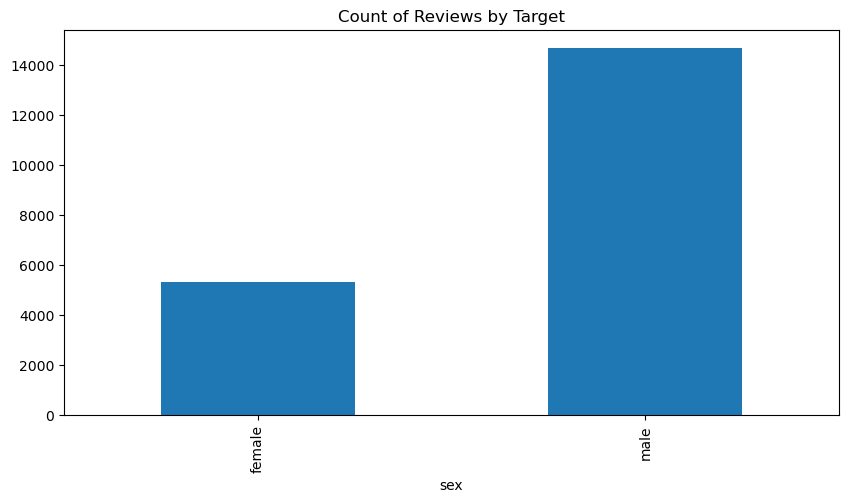

In [5]:
check_class_imbalance(df,df['sex'],'sex')

# Class Imabalance exists, we wil have to use voer sampling techniques

In [6]:
df['play_name'].value_counts()

Cymbeline                      3755
All's Well That Ends Well      2925
Love's Labours Lost            2862
Measure for Measure            2833
As You Like It                 2676
The\nMerry Wives of Windsor    2615
The Comedy of Errors           1962
The Merchant of Venice          372
Name: play_name, dtype: int64

In [7]:
df['genre'].value_counts()

Comedy    20000
Name: genre, dtype: int64

In [8]:
df['scene'].value_counts()

1    6000
2    5624
3    3387
4    2238
5    1913
6     560
7     278
Name: scene, dtype: int64

In [9]:
df['character'].value_counts()

Duke Vincentio         851
Rosalind               677
Imogen                 605
Biron                  599
Helena                 473
                      ... 
Scene Iii                1
Fourth Lord              1
As Long As You Or I      1
Armado                   1
Gaoler                   1
Name: character, Length: 172, dtype: int64

In [10]:
df['sex'] = df['sex'].apply(lambda x: 0 if x =='male' else 1)

In [12]:
df

,Unnamed: 0,play_name,genre,character,act,scene,sentence,text,sex
0,0,All's Well That Ends Well,Comedy,Countess,1,1,1,"In delivering my son from me, I bury a second ...",1
1,1,All's Well That Ends Well,Comedy,Bertram,1,1,2,"And I in going, madam, weep o'er my father's d...",0
2,2,All's Well That Ends Well,Comedy,Bertram,1,1,3,"anew: but I must attend his majesty's command, to",0
3,3,All's Well That Ends Well,Comedy,Bertram,1,1,4,"whom I am now in ward, evermore in subjection.",0
4,4,All's Well That Ends Well,Comedy,Lafeu,1,1,5,"You shall find of the king a husband, madam; you,",0
...,...,...,...,...,...,...,...,...,...
19995,19995,The Merchant of Venice,Comedy,Shylock,1,3,51,I cannot instantly raise up the gross,0
19996,19996,The Merchant of Venice,Comedy,Shylock,1,3,52,Of full three thousand ducats. What of that?,0
19997,19997,The Merchant of Venice,Comedy,Shylock,1,3,53,"Tubal, a wealthy Hebrew of my tribe,",0
19998,19998,The Merchant of Venice,Comedy,Shylock,1,3,54,Will furnish me. But soft! how many months,0


In [20]:
df['len_text'] = df['text'].apply(lambda x: len(x))
df['num_words'] = df['text'].apply(lambda x: len(x.split())) 

# Visuals

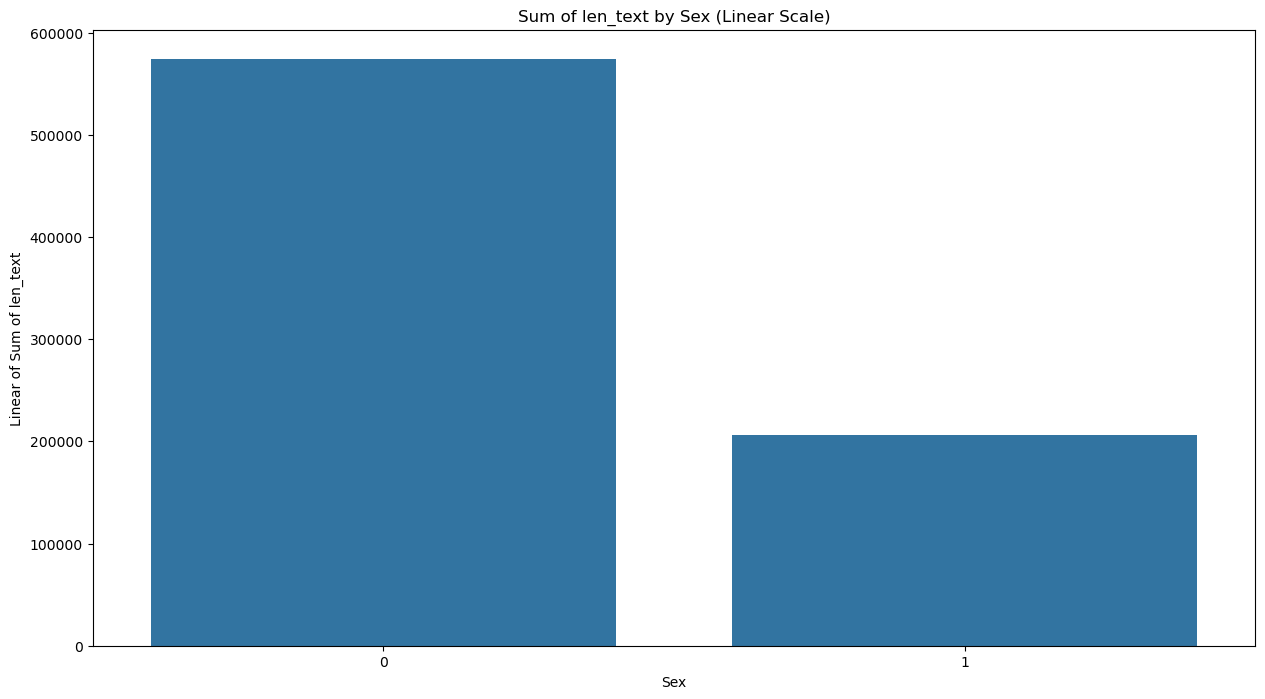

In [32]:
len_text_summary = df.groupby('sex')['len_text'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=len_text_summary, x='sex', y='len_text')
plt.yscale('linear')
plt.title('Sum of len_text by Sex (Linear Scale)')
plt.xlabel('Sex')
plt.ylabel('Linear of Sum of len_text')
plt.show()

# From our graph, we see that men talk far more than women in all plays

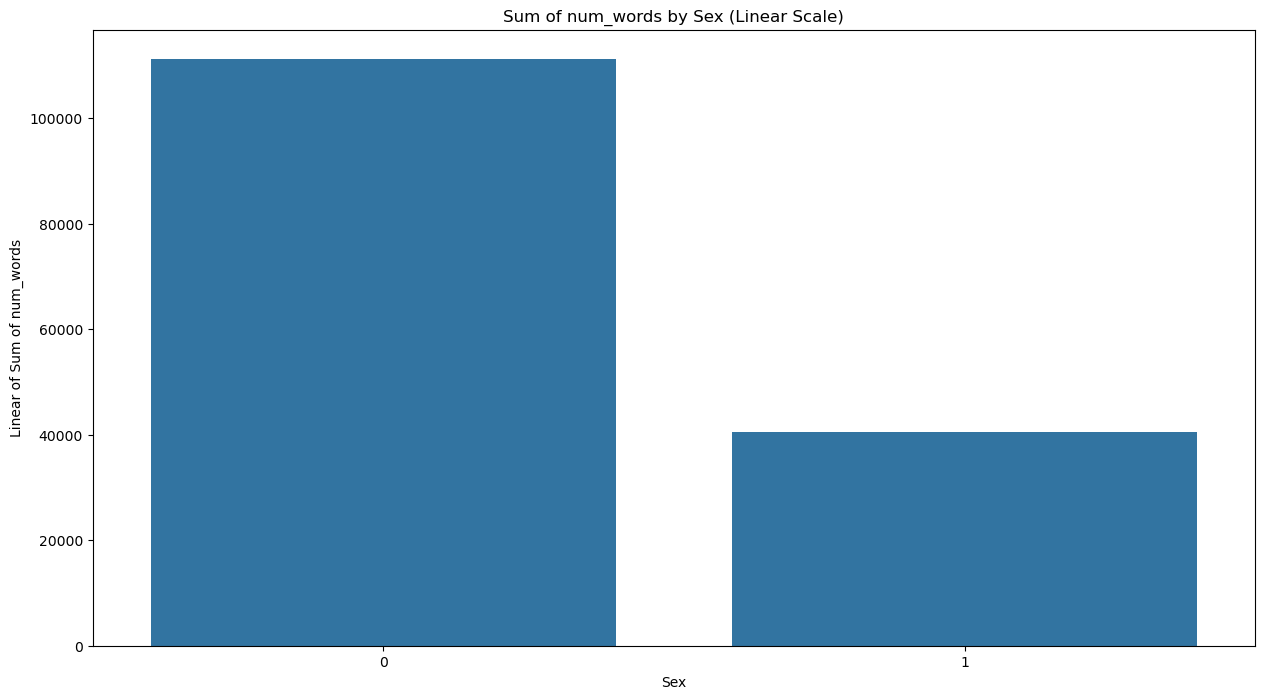

In [33]:
len_text_summary = df.groupby('sex')['num_words'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=len_text_summary, x='sex', y='num_words')
plt.yscale('linear')
plt.title('Sum of num_words by Sex (Linear Scale)')
plt.xlabel('Sex')
plt.ylabel('Linear of Sum of num_words')
plt.show()

# TFIDF Method

In [34]:
tfidf_df = df[['text', 'sex']]

tfidf_df['text'].apply(lambda text: remove_stop_words(text))

0          delivering son  bury second husband
1        going  madam  weep oer father s death
2               anew  attend majesty s command
3                    ward  evermore subjection
4                    shall king husband  madam
                         ...                  
19995                    instantly raise gross
19996                          thousand ducats
19997              tubal  wealthy hebrew tribe
19998                    furnish  soft  months
19999                                   desire
Name: text, Length: 20000, dtype: object

# Feature Variables

In [ ]:
X,y = df.drop("target", axis=1), df['target']

# Data Pipeline

In [35]:
X,y = tfidf_df['text'], tfidf_df['sex']

In [49]:
vectorizer = TfidfVectorizer(max_features=200)


tfidf_matrix = vectorizer.fit_transform(tfidf_df['text'])
tfidf_fit = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Baseline Model Performance

In [50]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='constant', constant=1) 

scores = evaluate_model(tfidf_fit, y, model)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.420 (0.000)


# Sampling Methods

In [51]:
X_res, y_res = sampling_methods(tfidf_fit, y)

# Advanced Model Metrics

In [47]:
names = ['LR']

models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
0,LR,0.664649,0.006102


In [52]:
names = ['SVC']

models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
0,SVC,0.764659,0.005633


In [53]:
names = ['XGB']

models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
0,XGB,0.68988,0.009162


In [54]:
names = ['RFC']

models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
0,RFC,0.769906,0.005694


In [55]:
names = ['GBC']

models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
0,GBC,0.618045,0.012153


In [56]:
names = ['DTC']

models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
0,DTC,0.694468,0.005786


In [57]:
names = ['LDA']

models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
0,LDA,0.579179,0.009234


In [58]:
names = ['KNN']

models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
0,KNN,0.696944,0.003817


# Bert Model

In [59]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = DistilBertModel.from_pretrained('distilbert-base-cased')

In [60]:
def get_embeddings(text:str):
    """
    - The function get_embeddings is designed to convert input text into a vector representation, 
    or embedding, using a transformer model 
    (like BERT or DistilBERT). These embeddings can be used for various 
    natural language processing tasks such as text classification, clustering, or similarity searches.
    
    - torch.no_grad(): This context manager tells PyTorch not to compute or store gradients. 
    This is important during inference when you only need to do forward propagation, 
    as it reduces memory consumption and speeds up computation.
    
    - last_hidden_state: This tensor contains the output features from the last layer of the 
    transformer for each token. 
    For models like BERT, this typically has dimensions 
    [batch_size, sequence_length, hidden_size]
    
    - This line calculates the mean of the last_hidden_state across the sequence length (tokens). 
    The mean operation reduces the tensor from [batch_size, sequence_length, hidden_size] 
    to [batch_size, hidden_size], resulting in a single vector representation for each 
    sequence in the batch. This vector captures the overall semantic meaning of the text.

    Args:
        text (str): _description_

    Returns:
        _type_: _description_
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state
    
    mean_embeddings = last_hidden_states.mean(dim=1)
    return mean_embeddings.numpy()

In [61]:
bert_df = df[['text', 'sex']]

In [ ]:
bert_df['text_embeddings'] = bert_df['text'].apply(lambda x: get_embeddings(x))

features = np.array(bert_df['text_embeddings'].tolist()).reshape(bert_df.shape[0], -1)